# Part III (Convexity Correction)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq, least_squares
from scipy.stats import norm
from scipy.integrate import quad
from math import log, exp, sqrt
from scipy import interpolate
from scipy.interpolate import CubicSpline

In [2]:
df_SABRImpVol = pd.read_csv('df_SABRImpVol.csv')
df_SABRImpVol.set_index(keys = df_SABRImpVol.columns[0], drop = True, inplace=True)
df_comb = pd.read_csv('df_comb.csv')
df_comb.set_index(keys = df_comb.columns[0], drop = True, inplace=True)

In [3]:
df_SABRImpVol

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps,FSR,α,ρ,ν
Unnamed: 0,,,,,,,,,,,,,,,,,
0,1Y,1Y,0.91570,0.62030,0.44130,0.31224,0.26182,0.2250,0.2096,0.2140,0.2434,0.27488,0.30297,0.032007,0.139074,-0.633226,2.049444
1,1Y,2Y,0.83270,0.61240,0.46570,0.35807,0.31712,0.2872,0.2712,0.2684,0.2851,0.31025,0.33523,0.033259,0.184632,-0.525124,1.677547
2,1Y,3Y,0.73920,0.56870,0.44770,0.35745,0.32317,0.2978,0.2829,0.2780,0.2877,0.30725,0.32833,0.034011,0.196838,-0.482828,1.438248
3,1Y,5Y,0.55190,0.44640,0.36510,0.30242,0.27851,0.2607,0.2498,0.2456,0.2512,0.26536,0.28165,0.035255,0.177968,-0.414034,1.065701
4,1Y,10Y,0.41180,0.35040,0.30207,0.26619,0.25351,0.2447,0.2398,0.2382,0.2425,0.25204,0.26355,0.038428,0.169925,-0.254155,0.792740
5,5Y,1Y,0.67800,0.49090,0.38400,0.31485,0.29060,0.2726,0.2604,0.2532,0.2494,0.25320,0.25980,0.039274,0.166617,-0.585660,1.340419
6,5Y,2Y,0.57880,0.46410,0.39033,0.33653,0.31531,0.2983,0.2856,0.2765,0.2671,0.26540,0.26760,0.040075,0.199548,-0.547118,1.062109
7,5Y,3Y,0.53430,0.44440,0.38180,0.33437,0.31536,0.2998,0.2876,0.2782,0.2667,0.26200,0.26150,0.040072,0.210349,-0.549822,0.936808
8,5Y,5Y,0.41990,0.36524,0.32326,0.29005,0.27677,0.2660,0.2573,0.2502,0.2406,0.23570,0.23400,0.041093,0.190266,-0.506963,0.674500


In [4]:
df_comb

,Tenor,OIS_Rate,OIS_DF,f,IRS_Rate,Foward_LIBOR,LIBOR_DF
Unnamed: 0,,,,,,,
0,0.5,0.00250,0.998752,0.002498,0.0250,0.025000,0.987654
1,1.0,0.00300,0.997009,0.002996,0.0280,0.031005,0.972577
2,1.5,NaN,0.995270,NaN,NaN,0.031751,0.957378
3,2.0,0.00325,0.993530,0.003495,0.0300,0.032264,0.942179
4,2.5,NaN,0.991773,NaN,NaN,0.034217,0.926331
5,3.0,0.00335,0.990015,0.003544,0.0315,0.034813,0.910482
6,3.5,NaN,0.988066,NaN,NaN,0.035208,0.894732
7,4.0,0.00350,0.986116,0.003946,0.0325,0.035839,0.878981
8,4.5,NaN,0.984150,NaN,NaN,0.034713,0.863985


In [5]:
#Tabulate the SABR parameter into dataframe for 2d interpolation
#index being the Expiry, Column been the Tenor
df_alpha = pd.DataFrame(data= df_SABRImpVol['α'].values.reshape(3,5), index= [1,5,10], columns = [1,2,3,5,10])
df_rho   = pd.DataFrame(data= df_SABRImpVol['ρ'].values.reshape(3,5), index= [1,5,10], columns = [1,2,3,5,10])
df_nu    = pd.DataFrame(data= df_SABRImpVol['ν'].values.reshape(3,5), index= [1,5,10], columns = [1,2,3,5,10])

In [6]:
df_alpha

,1,2,3,5,10
1,0.139074,0.184632,0.196838,0.177968,0.169925
5,0.166617,0.199548,0.210349,0.190266,0.175077
10,0.178247,0.196311,0.208236,0.202485,0.179410


In [7]:
df_rho

,1,2,3,5,10
1,-0.633226,-0.525124,-0.482828,-0.414034,-0.254155
5,-0.585660,-0.547118,-0.549822,-0.506963,-0.420208
10,-0.548311,-0.547527,-0.553546,-0.566329,-0.504683


In [8]:
df_nu

,1,2,3,5,10
1,2.049444,1.677547,1.438248,1.065701,0.792740
5,1.340419,1.062109,0.936808,0.674500,0.511096
10,1.010145,0.928629,0.871643,0.723756,0.582162


In [9]:
def Black76Lognormal(F, K, T, r, sigma, opt):
    d1 = (log(F/K)+(sigma*sigma/2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    if opt == 'Call':
        return F*exp(-r*T)*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)
    elif opt == 'Put':
        return K*exp(-r*T)*norm.cdf(-d2) - F*exp(-r*T)*norm.cdf(-d1)
    
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

#### Linear Interpolating Functions

In [10]:
#linear interpolate LIBOR DF based on Time
def LIBORDF(T):
    x = list(df_comb['Tenor'])
    y = list(df_comb['LIBOR_DF'])
    return np.interp(T, x, y)

#linear interpolate OIS DF based on Time
def OISDF(T):
    x = list(df_comb['Tenor'])
    y = list(df_comb['OIS_DF'])
    return np.interp(T, x, y)

# using cubic spline to interpolate SABR parameters
def ParameterInterp (expiry, tenor, data):
    splied_from_expiry = []
    for i in [1,2,3,5,10]:
        result = CubicSpline([1, 5, 10], data[i], bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
        splied_from_expiry.append(result)

    extract = []
    for i in range(5):
        extract.append(splied_from_expiry[i](expiry))

    result = CubicSpline([1,2,3,5,10], extract, bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
    return float(result(tenor))

#### Testing of Cubic Spline Interpolator

          1         2         3         5         10
1   0.139074  0.184632  0.196838  0.177968  0.169925
5   0.166617  0.199548  0.210349  0.190266  0.175077
10  0.178247  0.196311  0.208236  0.202485  0.179410


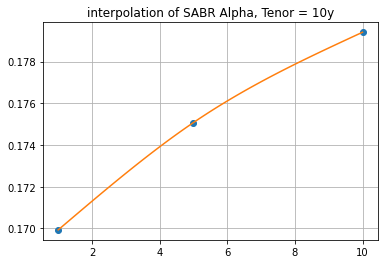

In [11]:
x_range = np.arange(1,10.1,0.1)
print(df_alpha)
plt.plot(df_alpha.index,df_alpha[10],"o")
plt.plot(x_range, [ParameterInterp(x, 10, df_alpha) for x in x_range])
plt.title("interpolation of SABR Alpha, Tenor = 10y")
plt.grid()
plt.show()

          1         2         3         5         10
1  -0.633226 -0.525124 -0.482828 -0.414034 -0.254155
5  -0.585660 -0.547118 -0.549822 -0.506963 -0.420208
10 -0.548311 -0.547527 -0.553546 -0.566329 -0.504683


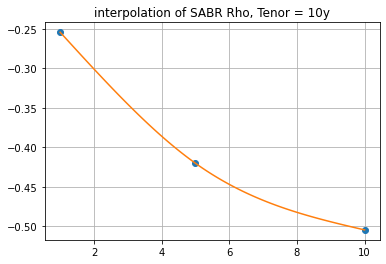

In [12]:
print(df_rho)
plt.plot(df_alpha.index,df_rho[10],"o")
plt.plot(x_range, [ParameterInterp(x, 10, df_rho) for x in x_range])
plt.title("interpolation of SABR Rho, Tenor = 10y")
plt.grid()
plt.show()

          1         2         3         5         10
1   2.049444  1.677547  1.438248  1.065701  0.792740
5   1.340419  1.062109  0.936808  0.674500  0.511096
10  1.010145  0.928629  0.871643  0.723756  0.582162


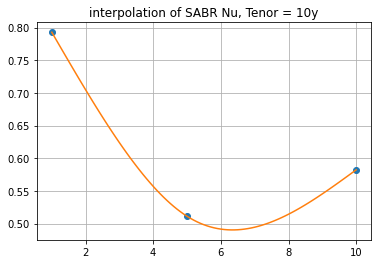

In [13]:
print(df_nu)
plt.plot(df_alpha.index,df_nu[10],"o")
plt.plot(x_range, [ParameterInterp(x, 10, df_nu) for x in x_range])
plt.title("interpolation of SABR Nu, Tenor = 10y")
plt.grid()
plt.show()

          1         2         3         5         10
1   0.139074  0.184632  0.196838  0.177968  0.169925
5   0.166617  0.199548  0.210349  0.190266  0.175077
10  0.178247  0.196311  0.208236  0.202485  0.179410


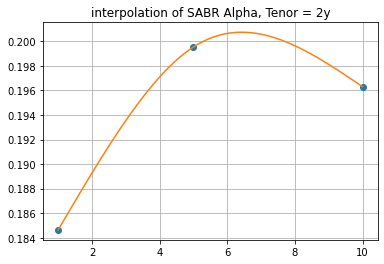

In [14]:
x_range = np.arange(1,10.1,0.1)
print(df_alpha)
plt.plot(df_alpha.index,df_alpha[2],"o")
plt.plot(x_range, [ParameterInterp(x, 2, df_alpha) for x in x_range])
plt.title("interpolation of SABR Alpha, Tenor = 2y")
plt.grid()
plt.show()

          1         2         3         5         10
1  -0.633226 -0.525124 -0.482828 -0.414034 -0.254155
5  -0.585660 -0.547118 -0.549822 -0.506963 -0.420208
10 -0.548311 -0.547527 -0.553546 -0.566329 -0.504683


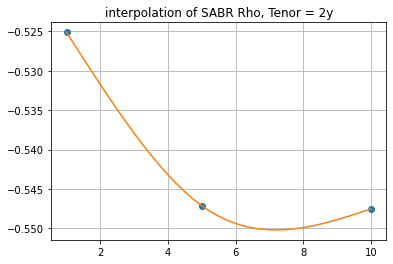

In [15]:
print(df_rho)
plt.plot(df_alpha.index,df_rho[2],"o")
plt.plot(x_range, [ParameterInterp(x, 2, df_rho) for x in x_range])
plt.title("interpolation of SABR Rho, Tenor = 2y")
plt.grid()
plt.show()

          1         2         3         5         10
1   2.049444  1.677547  1.438248  1.065701  0.792740
5   1.340419  1.062109  0.936808  0.674500  0.511096
10  1.010145  0.928629  0.871643  0.723756  0.582162


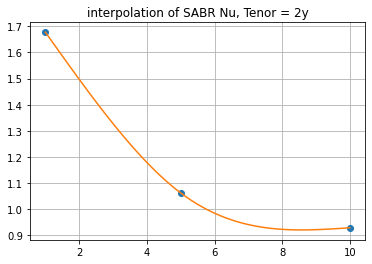

In [16]:
print(df_nu)
plt.plot(df_alpha.index,df_nu[2],"o")
plt.plot(x_range, [ParameterInterp(x, 2, df_nu) for x in x_range])
plt.title("interpolation of SABR Nu, Tenor = 2y")
plt.grid()
plt.show()

$ Forward\ LIBOR = L(T_{i-1} , T_{i}) = \frac{1}{Delta} * \frac{D_0(0, T_{i-1}) - D_0(0, T_i)}{D_0(0, T_i)}$

In [17]:
#forward LIBOR from discount factor
def F_LIBOR(D1,D2,delta):
    forward_LIBOR = (1/delta)*((D1-D2)/D2)
    return forward_LIBOR

$ Forward\ Swap\ Rate = \frac {Floating\ Leg}{Fixed\ Leg} = \frac{\sum_{n=i}^{N} D_0(0, T_i) * L(T_i, T_{i-1}) * delta}{\sum_{n=i}^{N} D_0(0,T_i)* delta} $

In [18]:
def Forward_SWAP_RATE(expiry, tenor, delta):   
    month = int(tenor/delta)#number of payment after during tenor period
    float_leg, fixed_leg = 0, 0 #initialize fix and floating leg
    
    for i in range(1,month+1):
        loc = expiry + i*delta
        # float leg = OIS discount factor x forward LIBOR x delta
        float_leg += OISDF(loc)*F_LIBOR(LIBORDF(loc-delta),LIBORDF(loc),delta)*delta

    for i in range(1,month+1):
        # Fixed leg = Sum of OIS discount factor from Expiry to Tenor end
        fixed_leg += OISDF(expiry + i*delta)*delta

    return float_leg/fixed_leg

$IRR  (K) = \sum_{i = 1}^{N * m} \frac{1}{m} *({1 + \frac{K}{m}})^{-i}\ \ \ \ \    (delta = \frac{1}{m})$

$IRR' (K) = \sum_{i = 1}^{N * m} (-i)*(\frac{1}{m})^2 *({1 + \frac{K}{m}})^{-i-1}\ \ \ \ \    (delta = \frac{1}{m})$

$IRR'' (K) = \sum_{i = 1}^{N * m} (-i)*(-i-1) *(\frac{1}{m})^3 *({1 + \frac{K}{m}})^{-i-2}\ \ \ \ \    (delta = \frac{1}{m})$

In [19]:
def IRR(Tenor, Delta, K):
    total = 0
    for i in np.arange(1, Tenor/Delta +1):
        total += Delta*(1 + K* Delta)**(-i)
    return total

def IRR_1st(Tenor, Delta, K):
    total = 0
    for i in np.arange(1, Tenor/Delta +1):
        total += (-i)*(Delta**2)*(1 + K* Delta)**(-i-1)
    return total

def IRR_2nd(Tenor, Delta, K):
    total = 0
    for i in np.arange(1, Tenor/Delta +1):
        total += (-i)*(-i-1)*(Delta**3)*(1 + K* Delta)**(-i-2)
    return total

$h''(K) = \frac{-IRR''(K) * K - 2 * IRR'(K)}{IRR(K)^2} + \frac{2 * IRR'(K)^2 * K}{IRR(K)^3}$

In [20]:
def h_2nd(Tenor, Delta, K):
    IRR0 = IRR(Tenor, Delta, K)
    IRR1 = IRR_1st(Tenor, Delta, K)
    IRR2 = IRR_2nd(Tenor, Delta, K) 
    return (-IRR2*K - 2*IRR1) / (IRR0**2) + 2*(IRR1**2)*K/(IRR0**3)

$ CMS\ Rate = E^T [S_{n,N}(T)]= g(F) + \frac{1}{D(0,T)} \left[\int_0^F h''(K)V^{rec}(K)dK + \int_F^\infty h''(K)V^{pay}(K)dK\right] $

In [21]:
def integrand(F, K, T, r, sigma, tenor, delta, opt):
    irr = IRR(tenor, delta, F)
    hppk = h_2nd(tenor, delta, K)
    return hppk*Black76Lognormal(F, K, T, r, sigma, opt)


def CMS(expiry, tenor, delta):
    F       = Forward_SWAP_RATE(expiry, tenor, delta)
    alpha   = ParameterInterp(expiry,tenor,df_alpha)
    rho     = ParameterInterp(expiry,tenor,df_rho)
    nu      = ParameterInterp(expiry,tenor,df_nu)
    VRec     = quad(lambda x:integrand(F,x,expiry,0,
                                      SABR(F,x,expiry,alpha,0.9,rho,nu),
                                      tenor, delta, 'Put'), 0, F)
    VPay     = quad(lambda x:integrand(F,x,expiry,0,
                                      SABR(F,x,expiry,alpha,0.9,rho,nu),
                                      tenor, delta, 'Call'), F, 0.1) 
    # Choose upper bound of integration as 0.075 because the highest strike we can observe from market data is 0.073434

    return F + VRec[0] + VPay[0]


$ CMS\ leg\ PV = \sum^{N}_{i=0.5} D_0(0, T_i) * delta * CMS(S_{n,N}(Ti)) \ \ \ \ \ \ (N = n+ swap\ tenor) $

In [22]:
def PV_CMS(tenor, cms_period, delta):
    n = int(cms_period/delta)
    pv = 0
    for i in range(1,n+1):
        loc = i*delta
        pv += OISDF(loc)*delta*CMS(loc,tenor,delta)
    return pv

### Question 1

Using the SABR model calibrated in the previous question, value the
following constant maturity swap (CMS) products:
- PV of a leg receiving CMS10y semi-annually over the next 5 years
- PV of a leg receiving CMS2y quarterly over the next 10 years

In [23]:
cms_period = 5
tenor = 10
delta = 0.5

PV = PV_CMS(tenor, cms_period, delta)
print('PV of a leg receiving CMS10y semi-annually over the next 5 years = ',PV )

PV of a leg receiving CMS10y semi-annually over the next 5 years =  0.20210873416095204


In [24]:
cms_period = 10
tenor = 2
delta = 0.25

PV = PV_CMS(tenor, cms_period, delta)
print('PV of a leg receiving CMS2y quarterly over the next 10 years = ',PV )

PV of a leg receiving CMS2y quarterly over the next 10 years =  0.3810596742011047


### Question 2

Compare the forward swap rates with the CMS rate:
- 1y  x 1y, 1y  x 2y,  1y x 3y, 1y  x 5y, 1y  x 10y
- 5y  x 1y, 5y  x 2y,  5y x 3y, 5y  x 5y, 5y  x 10y
- 10y x 1y, 10y x 2y, 10y x 3y, 10y x 5y, 10y x 10y

In [25]:
#calculate CMS rates
Exipry = [1, 5, 10]
Tenor = [1, 2, 3, 5, 10]
delta = 0.5

CMS_list = []
for i in Exipry:
    for j in Tenor:
        CMS_list.append(CMS(i,j,delta))

In [26]:
Index = ['1 x 1', '1 x 2', '1 x 3', '1 x 5', '1 x 10',
         '5 x 1', '5 x 2', '5 x 3', '5 x 5', '5 x 10',
         '10 x 1', '10 x 2', '10 x 3', '10 x 5', '10 x 10']

In [27]:
summary = pd.DataFrame({'CMS_rate':CMS_list, 'Forward_Swap_rate':df_SABRImpVol["FSR"].values }, index = Index)
summary

,CMS_rate,Forward_Swap_rate
1 x 1,0.032120,0.032007
1 x 2,0.033381,0.033259
1 x 3,0.034120,0.034011
1 x 5,0.035326,0.035255
1 x 10,0.038496,0.038428
5 x 1,0.040129,0.039274
5 x 2,0.040756,0.040075
5 x 3,0.040664,0.040072
5 x 5,0.041534,0.041093
5 x 10,0.044057,0.043634


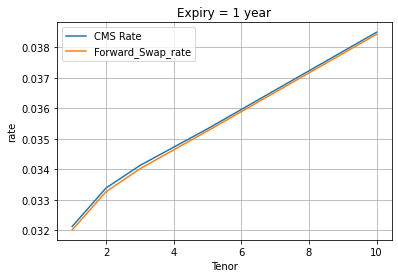

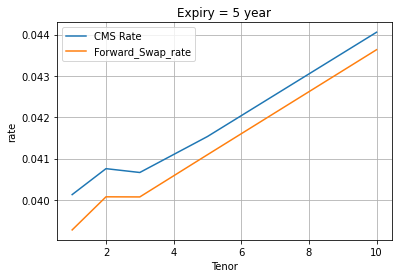

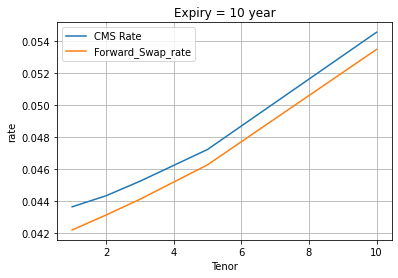

In [28]:
title_list = ['Expiry = 1 year', 'Expiry = 5 year', 'Expiry = 10 year']
for i in range(3):
    plt.plot(Tenor,summary["CMS_rate"][i*5:(i+1)*5],label="CMS Rate")
    plt.plot(Tenor,summary["Forward_Swap_rate"][i*5:(i+1)*5],label="Forward_Swap_rate")
    plt.title(title_list[i])
    plt.ylabel("rate")
    plt.xlabel("Tenor")
    plt.legend()
    plt.grid()
    plt.show()